# Set Up

In [45]:
%pwd

'/pscratch/sd/m/mansisak/memorization/figs'

In [46]:
!module load conda

In [47]:
!conda activate /pscratch/sd/m/mansisak/memorization/env/

In [48]:
ls 

csv/                        math_bd_train.pdf*
lm_bd_reg.pdf*              math_noise_reg.pdf*
lm_bd_test_perplexity.pdf*  math_noise_test_acc.pdf*
lm_bd_train_loss.pdf*       math_noise_train_loss.pdf*
lm_bd_train.pdf*            math_noise_train.pdf*
lm_dup_noise_train.pdf*     pythia_compare_localization_over_time_plot.pdf
lm_noise_reg.pdf*           pythia_localization_hp_scatter_plot.pdf
math_bd_reg.pdf*            pythia_unlearning_results.ipynb
math_bd_test_acc.pdf*       vis/
math_bd_train_loss.pdf*


In [49]:
import pandas as pd
import numpy as np
import torch
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Check if experiments finished

In [200]:
def check_if_hp_run_fin(csv, model_name):
    total_exp = 0
    total_finished = 0

    df = pd.read_csv(csv)
    mask = df.localization_method == "base_stats"

    for loc_method in [
      "act",
      "hc",
      "slim",
      "durable",
      "durable_agg",
      "random",
      "random_greedy",
      "greedy",
  ]:
        for ratio in [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25, 0.3, 0.5, 0.8]:
            if loc_method not in ["random", "random_greedy"]:
                if ratio >= 0.1:
                    continue

          # this ratio is too small for neuron-level methods
            if loc_method in ["zero", "hc", "ig", "slim", "act"]:
                if ratio <= 0.0001:
                    continue

            if loc_method in ["greedy"]:
                if ratio > 0.00001:
                    continue

            if loc_method in ["slim", "hc", "random"]:
                for epochs in [1, 10, 20]:
                    total_exp += 1
                    if ((df['ratio'] == ratio) & (df['localization_method'] == loc_method) & (df['epochs'] == epochs) & (df['model_name'] == model_name)).any():
                      #print("finsihed")
                      total_finished += 1
                        
            if loc_method in ["random_greedy"]:
                for epochs in [1, 10, 20]:
                    for loss_weighting in [0.9, 0.7, 0.5]:
                        total_exp += 1
                        if ((df['ratio'] == ratio) & (df['localization_method'] == loc_method) & (df['epochs'] == epochs) & (df['loss_weighting'] == loss_weighting)& (df['model_name'] == model_name)).any():
                          #print("finsihed")
                          total_finished += 1
                        #else:
                        #    print(f'{loc_method} {ratio} {epochs} {loss_weighting}')
                            
                        

                #here we check ratio, loc_method, epoch
            if loc_method in ["zero", "act", 'durable', 'durable_agg', 'greedy',]:
                total_exp += 1
                if ((df['ratio'] == ratio) & (df['localization_method'] == loc_method)& (df['model_name'] == model_name)).any():
                    #print("finsihed")
                    total_finished += 1
            #here we check ratio, loc_method

  #print("total experiments: ", total_exp)
    print(f"total finished: {total_finished}/{total_exp}")
    if total_exp == total_finished:
        return 1
    return 

In [201]:
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"
        result_path = f"/pscratch/sd/m/mansisak/memorization/model_ckpts/{step}/EleutherAI_edit/"
        csv = (f'{result_path}{file_name}')
        print(csv)

        check_if_hp_run_fin(csv, model_name)

STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped
/pscratch/sd/m/mansisak/memorization/model_ckpts/36000/EleutherAI_edit/localization_results_36000.csv
total finished: 126/152
STEP:  72000  model_name:   EleutherAI/pythia-6.9b-deduped
/pscratch/sd/m/mansisak/memorization/model_ckpts/72000/EleutherAI_edit/localization_results_72000.csv
total finished: 126/152
STEP:  108000  model_name:   EleutherAI/pythia-6.9b-deduped
/pscratch/sd/m/mansisak/memorization/model_ckpts/108000/EleutherAI_edit/localization_results_108000.csv
total finished: 120/152
STEP:  143000  model_name:   EleutherAI/pythia-6.9b-deduped
/pscratch/sd/m/mansisak/memorization/model_ckpts/143000/EleutherAI_edit/localization_results_143000.csv
total finished: 117/152
STEP:  36000  model_name:   EleutherAI/pythia-2.8b-deduped
/pscratch/sd/m/mansisak/memorization/model_ckpts/36000/EleutherAI_edit/localization_results_36000.csv
total finished: 152/152
STEP:  72000  model_name:   EleutherAI/pythia-2.8b-deduped
/pscratch/

# Load in Results + Visualize Tables of unlearning @ different time points/models

In [117]:
result_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/143000/EleutherAI_edit/"

file_name = "localization_results_143000.csv"

df = pd.read_csv(f'{result_path}{file_name}')

base_stats = df.loc[0].copy()
df = df.drop_duplicates()
df.head()

,model_name,localization_method,ratio,batch_size,epochs,lambda_l1,stop_loss,lr,prompt_len,ig_steps,...,step,assess_mem,seed,loss_weighting,model_path,results_path,perc,perp,total_time,unlearn_set_name
0,EleutherAI/pythia-2.8b-deduped,hc,0.010,16,1,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,0.534653,21.980392,NaN,NaN
1,EleutherAI/pythia-2.8b-deduped,hc,0.010,16,1,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,0.223762,26.647059,2.484289,mem
2,EleutherAI/pythia-2.8b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,0.263366,22.392157,7.986578,mem
3,EleutherAI/pythia-2.8b-deduped,act,0.010,32,1,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,0.136634,23.921569,NaN,mem
4,EleutherAI/pythia-2.8b-deduped,act,0.050,32,1,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,0.089109,27.901961,NaN,mem


In [53]:
df[(df['ratio'] == 0.8) & (df['localization_method'] == "random_greedy") & (df['epochs'] == 1) & (df['loss_weighting'] == 0.7)]

,model_name,localization_method,ratio,batch_size,epochs,lambda_l1,stop_loss,lr,prompt_len,ig_steps,...,step,assess_mem,seed,loss_weighting,model_path,results_path,perc,perp,total_time,unlearn_set_name
231,EleutherAI/pythia-2.8b-deduped,random_greedy,0.8,32,1,1000,0.1,0.1,32,1,...,143000,0,0,0.7,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,0.0,inf,89.841159,mem


In [54]:
df[df['unlearn_set_name'].isna()]

,model_name,localization_method,ratio,batch_size,epochs,lambda_l1,stop_loss,lr,prompt_len,ig_steps,...,step,assess_mem,seed,loss_weighting,model_path,results_path,perc,perp,total_time,unlearn_set_name
0,EleutherAI/pythia-2.8b-deduped,hc,0.010,16,1,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,0.534653,21.980392,NaN,NaN
5,EleutherAI/pythia-6.9b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-6.9...,../../model_ckpts/143000/EleutherAI_edit/local...,0.893069,19.460784,NaN,NaN


In [55]:
df = df[["perc", "perp",'localization_method','ratio']]
new = df[(df.perp < 50)]
new = new[new.perc < 0.1]

new[new.localization_method == "random_greedy"]

,perc,perp,localization_method,ratio
147,0.029703,48.627451,random_greedy,0.001
152,0.057426,30.470588,random_greedy,0.001
157,0.091089,23.019608,random_greedy,0.010
162,0.043564,32.333333,random_greedy,0.010
166,0.083168,24.607843,random_greedy,0.050
218,0.065347,28.274510,random_greedy,0.001
247,0.071287,25.352941,random_greedy,0.010
255,0.065347,22.725490,random_greedy,0.050


In [112]:
(new.perc < -2).any()

False

In [193]:
import statistics
import math
def return_ideal_method_for_lang(base_early_stats, weight_early, perp_cutoff=500, mem_cutoff=100, backdoor=False):
  #desired columns
  cols = ["perc", "perp",'localization_method','ratio','epochs','loss_weighting','total_time']
  loc_methods = ['greedy', 'durable', 'durable_agg', 'random', 'random_greedy', "hc", "slim", 'act', ]
  weight_early = weight_early[(weight_early.perp < perp_cutoff)]

  #weight_early = weight_early[weight_early.perc < mem_cutoff]
    
  dfs = []
  for loc_method in loc_methods:
    mask = ((weight_early.localization_method == loc_method)  & (weight_early.perc < mem_cutoff))
    if mask.any():
        dfs.append(weight_early[mask].copy())
    else:
        #print(weight_early.localization_method.unique())
        #print("loc_method:", loc_method)
        mask = (weight_early.localization_method == loc_method)
        #print(mask)
        dfs.append(weight_early[mask].copy())
    #print(len(dfs))
  weight_early = pd.concat(dfs, axis=0)

  #Convert base stats to a df
  base_frame = base_early_stats.to_frame().T[cols]

  #Generate Percent Differences
  weight_early["perc_diff"] =  (weight_early['perc'] - base_early_stats['perc']) /  base_early_stats['perc']


  weight_early["perp_diff"] = (weight_early['perp'] - base_early_stats['perp']) /  base_early_stats['perp']

  weight_early["score"] = 0 # zero initialize -- we will populate it below

  #Compute Scores
  for index, row in weight_early.iterrows():
    if row['unlearn_set_name'] == "mem":
        if row['perc_diff'] == 0:
            weight_early.loc[index, "score"] += 100 # this is how we penalize zero perc drop in mem
        weight_early.loc[index, "score"] += (row['perc_diff'])



        weight_early.loc[index, "score"] += statistics.mean([row['perp_diff']])

  df = pd.DataFrame(columns=cols)
  #append base stats to df
  base_frame['localization_method'] = "BASE_STATS"
  df = pd.concat([df, base_frame])

  #Print out ideal method for each dist based on the min score
  for unlearn_set in loc_methods:
    #print(unlearn_set)
    subset = weight_early.loc[weight_early['localization_method'] == unlearn_set]
    if subset.shape[0] == 0:
      #print("no results yet for: ", unlearn_set)
      continue
    sub_frame = subset[subset.score == subset.score.min()].drop_duplicates()
    sub_frame = sub_frame[cols]
    #print(sub_frame)
    df = pd.concat([df, sub_frame])

  df[['ratio',]] *= 100

  return df.drop_duplicates()


In [188]:
df.localization_method.unique()

array(['hc', 'act', 'slim', 'durable', 'durable_agg', 'random',
       'random_greedy', 'greedy'], dtype=object)

In [194]:
result_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/143000/EleutherAI_edit/"

file_name = "localization_results_143000.csv"

df = pd.read_csv(f'{result_path}{file_name}')
df.perc *= 100
base_stats = df.loc[0].copy()
df = df.drop_duplicates()
df.head()

return_ideal_method_for_lang(base_stats, df, perp_cutoff= 500, mem_cutoff=20, backdoor=False)

/tmp/ipykernel_1975860/532111167.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.918518520686239' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])


,perc,perp,localization_method,ratio,epochs,loss_weighting,total_time
0,53.465348,21.980392,BASE_STATS,1.0,1,0.05,NaN
244,4.356436,32.352941,greedy,0.001,1,0.05,7545.783458
53,6.138614,33.058824,durable,0.01,1,0.05,10.247648
60,4.554456,38.686275,durable_agg,0.01,1,0.05,438.042559
118,19.009902,22.764706,random,5.0,1,0.05,111.099959
255,6.534654,22.72549,random_greedy,5.0,1,0.7,233.418606
36,13.663366,26.980392,hc,5.0,10,0.05,NaN
28,31.881189,23.215686,slim,5.0,1,0.05,NaN
29,31.881189,23.215686,slim,5.0,10,0.05,NaN
31,31.881189,23.215686,slim,5.0,20,0.05,NaN


In [176]:
dfs = []

for loc_method in ["slim", "act"]:
    mask = ((df.localization_method == loc_method)  & (df.perc < 10))
    if mask.any():
        dfs.append(df[mask])
    else:
        mask = (df.localization_method == loc_method)
        dfs.append(df[mask].copy())
pd.concat(dfs, axis=0)

,model_name,localization_method,ratio,batch_size,epochs,lambda_l1,stop_loss,lr,prompt_len,ig_steps,...,step,assess_mem,seed,loss_weighting,model_path,results_path,perc,perp,total_time,unlearn_set_name
20,EleutherAI/pythia-2.8b-deduped,slim,0.001,32,1,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,52.871287,21.980392,1.981384,mem
21,EleutherAI/pythia-2.8b-deduped,slim,0.001,32,10,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,52.871287,21.980392,17.367561,mem
22,EleutherAI/pythia-2.8b-deduped,slim,0.001,32,20,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,52.871287,21.980392,34.429817,mem
23,EleutherAI/pythia-2.8b-deduped,slim,0.010,32,1,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,50.891089,22.176471,NaN,mem
25,EleutherAI/pythia-2.8b-deduped,slim,0.010,32,10,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,50.891089,22.176471,NaN,mem
26,EleutherAI/pythia-2.8b-deduped,slim,0.010,32,20,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,50.891089,22.176471,NaN,mem
28,EleutherAI/pythia-2.8b-deduped,slim,0.050,32,1,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,31.881189,23.215686,NaN,mem
29,EleutherAI/pythia-2.8b-deduped,slim,0.050,32,10,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,31.881189,23.215686,NaN,mem
31,EleutherAI/pythia-2.8b-deduped,slim,0.050,32,20,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,31.881189,23.215686,NaN,mem
41,EleutherAI/pythia-6.9b-deduped,slim,0.001,32,1,1000,0.1,0.1,32,1,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-6.9...,../../model_ckpts/143000/EleutherAI_edit/local...,86.534655,19.490196,5.653414,mem


In [127]:
df.perc

0      53.465348
1      22.376238
2      26.336634
3      13.663366
4       8.910891
         ...    
267     0.000000
268     0.000000
269     0.000000
270     0.198020
271     0.000000
Name: perc, Length: 272, dtype: float64

In [57]:
# need to add in % differences before and after edit

def generate_perc_diffs(df, base_stats):
    #Generate Percent Differences
    df["perc_diff"] =  100* (df['perc'] - base_stats['perc']) /  base_stats['perc']
    df["perp_diff"] = 100* (df['perp'] - base_stats['perp']) /  base_stats['perp']
    return df

STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped
0 0
STEP:  72000  model_name:   EleutherAI/pythia-6.9b-deduped
1 0
STEP:  108000  model_name:   EleutherAI/pythia-6.9b-deduped
2 0
STEP:  143000  model_name:   EleutherAI/pythia-6.9b-deduped
3 0
STEP:  36000  model_name:   EleutherAI/pythia-2.8b-deduped
0 1
STEP:  72000  model_name:   EleutherAI/pythia-2.8b-deduped
1 1
STEP:  108000  model_name:   EleutherAI/pythia-2.8b-deduped
2 1
STEP:  143000  model_name:   EleutherAI/pythia-2.8b-deduped
3 1


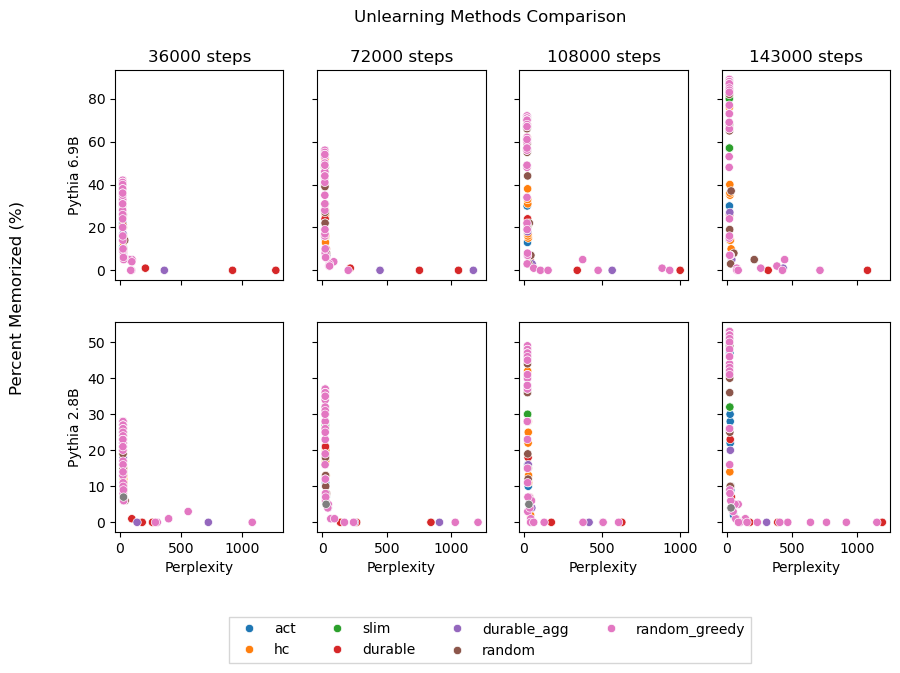

In [58]:
fig, axs = plt.subplots( 2, 4, sharex="col", sharey='row', figsize=(10,6))
fig.suptitle('Unlearning Methods Comparison')
fig.supylabel("Percent Memorized (%)")


y_idx = 0
x_idx = 0


dfs = []
x_idx = 0
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    y_idx = 0
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"
        result_path = f"/pscratch/sd/m/mansisak/memorization/model_ckpts/{step}/EleutherAI_edit/"

        df = pd.read_csv(f'{result_path}{file_name}')
        for col in df.columns:
            if col in ["perc"]:
                df[col] = df[col].apply(lambda x: round(x, 2))
                df[col] = df[col].apply(lambda x: int(x*100))
            if col in ["perp"]:
                df[col] = df[col].apply(lambda x: int(x) if x < 10000 else x)
            if col in ['ratio']:
                df[col] = df[col].apply(lambda x: round(x, 6))
        df = df[df['model_name'] == model_name]
        #base_stats = df.loc[0].copy()
        base_stats = df[df['unlearn_set_name'].isna()].iloc[0]
        df = df.drop_duplicates()
        #df = return_ideal_method_for_lang(base_stats, df, backdoor=False)
        #print(df)
        dfs.append(copy.deepcopy(df))
        ax = sns.scatterplot(x="perp",
                y="perc",
                data=df,
                hue="localization_method", ax=axs[x_idx, y_idx])
        ax.set_xlabel("Perplexity")
        #ax.set_ylabel("Percent Difference in Memorization Post-Edit (%)")
        ax.get_legend().remove()

        print(y_idx, x_idx)
        y_idx += 1
    x_idx += 1

rows = ["Pythia 6.9B", "Pythia 2.8B"]
for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row)

cols = [36000, 72000, 108000, 143000]
for ax, col in zip(axs[0], cols):
    ax.set_title(f'{col} steps')
        #plt.show()

#fig.legend(lines, labels, loc = (0.5, 0), ncol=5)
handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center')
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, -0.02),fancybox=False, shadow=False, ncol=4)
plt.savefig(f"pythia_localization_hp_scatter_plot.pdf", bbox_inches='tight')

STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped
0 0
STEP:  72000  model_name:   EleutherAI/pythia-6.9b-deduped
1 0
STEP:  108000  model_name:   EleutherAI/pythia-6.9b-deduped
2 0
STEP:  143000  model_name:   EleutherAI/pythia-6.9b-deduped
3 0
STEP:  36000  model_name:   EleutherAI/pythia-2.8b-deduped
0 1
STEP:  72000  model_name:   EleutherAI/pythia-2.8b-deduped
1 1
STEP:  108000  model_name:   EleutherAI/pythia-2.8b-deduped
2 1
STEP:  143000  model_name:   EleutherAI/pythia-2.8b-deduped
3 1


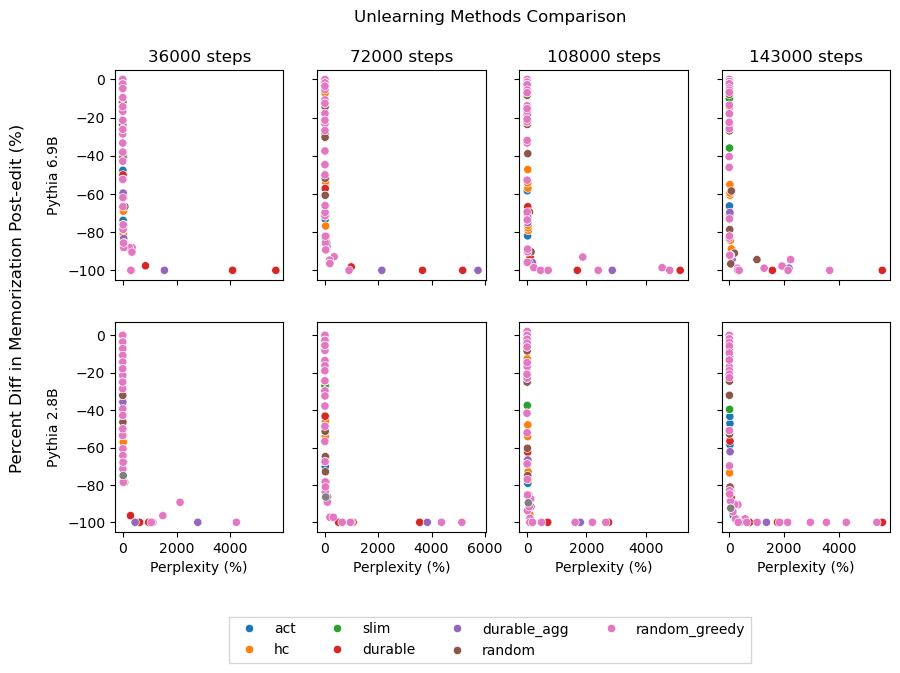

In [59]:
fig, axs = plt.subplots( 2, 4, sharex="col", sharey='row', figsize=(10,6))
fig.suptitle('Unlearning Methods Comparison')
fig.supylabel("Percent Diff in Memorization Post-edit (%)")


y_idx = 0
x_idx = 0


dfs = []
x_idx = 0
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    y_idx = 0
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"
        result_path = f"/pscratch/sd/m/mansisak/memorization/model_ckpts/{step}/EleutherAI_edit/"

        df = pd.read_csv(f'{result_path}{file_name}')
        for col in df.columns:
            if col in ["perc"]:
                df[col] = df[col].apply(lambda x: round(x, 2))
                df[col] = df[col].apply(lambda x: int(x*100))
            if col in ["perp"]:
                df[col] = df[col].apply(lambda x: int(x) if x < 10000 else x)
            if col in ['ratio']:
                df[col] = df[col].apply(lambda x: round(x, 6))
        df = df[df['model_name'] == model_name]
        #base_stats = df.loc[0].copy()
        base_stats = df[df['unlearn_set_name'].isna()].iloc[0]
        df = generate_perc_diffs(df, base_stats)
        df = df.drop_duplicates()
        #df = return_ideal_method_for_lang(base_stats, df, backdoor=False)
        #print(df)
        dfs.append(copy.deepcopy(df))
        ax = sns.scatterplot(x="perp_diff",
                y="perc_diff",
                data=df,
                hue="localization_method", ax=axs[x_idx, y_idx])
        ax.set_xlabel("Perplexity (%)")
        #ax.set_ylabel("Percent Difference in Memorization Post-Edit (%)")
        ax.get_legend().remove()

        print(y_idx, x_idx)
        y_idx += 1
    x_idx += 1

rows = ["Pythia 6.9B", "Pythia 2.8B"]
for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row)

cols = [36000, 72000, 108000, 143000]
for ax, col in zip(axs[0], cols):
    ax.set_title(f'{col} steps')
        #plt.show()

#fig.legend(lines, labels, loc = (0.5, 0), ncol=5)
handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center')
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, -0.02),fancybox=False, shadow=False, ncol=4)
plt.savefig(f"pythia_localization_hp_scatter_plot.pdf", bbox_inches='tight')

In [90]:
# add in timing for all of the

def fill_in_neuron_time(df):
  # we are just filtering out things that were accidentally included in the HP sweep that shouldn't have been
  mask = (df.localization_method.isin(["hc","random_greedy","random","hc","slim","ig"])) & (df.batch_size == 512)
  df = df[~mask]
  # filter batch size of
  # no hp: zero, act, ig
  #print("hello")
  df.drop(df[(df.localization_method =="ig") & (df.batch_size == 512)].index, inplace=True)
  for model_name in ["EleutherAI/pythia-2.8b-deduped", "EleutherAI/pythia-6.9b-deduped"]:
      for localization_method in ['zero', 'act', 'ig']:
        if localization_method in list(df['localization_method']):
          time = df[(df['localization_method']==localization_method) & (df['total_time'] > 0) & (df['model_name'] == model_name) ].total_time.item()
          #print(time)
          df.loc[(df['localization_method']==localization_method) & (df['total_time'].isna()& (df['model_name'] == model_name)), 'total_time'] = time

      # epoch: hc, slim
      for localization_method in ['hc', 'slim']:
        if localization_method in list(df['localization_method']):
          for epochs in [1, 10, 20]:
            if epochs in list(df[(df['localization_method']==localization_method)].epochs):
              time = df[(df['localization_method']==localization_method) & (df['total_time'] > 0) & (df['epochs']==epochs)& (df['model_name'] == model_name)].total_time.item()
              df.loc[(df['localization_method']==localization_method) &  (df['epochs']==epochs) &(df['total_time'].isna()& (df['model_name'] == model_name)), 'total_time'] = time

  return df

In [202]:
dfs = []
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"
        result_path = f"/pscratch/sd/m/mansisak/memorization/model_ckpts/{step}/EleutherAI_edit/"

        df = pd.read_csv(f'{result_path}{file_name}')
        df = fill_in_neuron_time(df)
        for col in df.columns:
            if col in ["perc"]:
                df[col] = df[col].apply(lambda x: round(x, 2))
                df[col] = df[col].apply(lambda x: int(x*100))
            if col in ["perp"]:
                df[col] = df[col].apply(lambda x: int(x) if x < 10000 else x)
            if col in ['ratio']:
                df[col] = df[col].apply(lambda x: round(x, 6))
        df = df[df['model_name'] == model_name]
        #base_stats = df.loc[0].copy()
        base_stats = df[df['unlearn_set_name'].isna()].iloc[0]
        df = df.drop_duplicates()
        dfs.append(copy.deepcopy(df))

        df = return_ideal_method_for_lang(base_stats, df, perp_cutoff= 500, mem_cutoff=10, backdoor=False)
        print(df)
        #print(df.to_latex(index=False))

STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped
    perc  perp localization_method ratio epochs loss_weighting  total_time
3     42  22.0          BASE_STATS   0.1      1           0.05   10.007435
52     9  28.0             durable  0.01      1           0.05    6.451955
59     7  30.0         durable_agg  0.01      1           0.05  560.031209
118   10  28.0              random   5.0     10           0.05  235.290785
254    9  24.0       random_greedy   5.0      1            0.7   214.57831
31     8  27.0                  hc   5.0      1           0.05    3.368649
47    37  23.0                slim   5.0      1           0.05    2.783565
48    37  23.0                slim   5.0     10           0.05   25.076685
49    37  23.0                slim   5.0     20           0.05   49.979251
9      8  26.0                 act   5.0      1           0.05   10.007435
STEP:  72000  model_name:   EleutherAI/pythia-6.9b-deduped
    perc   perp localization_method ratio epochs loss_wei

/tmp/ipykernel_1975860/532111167.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.7857142857142857' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])
/tmp/ipykernel_1975860/532111167.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.9821428571428571' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])
/tmp/ipykernel_1975860/532111167.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.9305555555555556' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])


    perc  perp localization_method ratio epochs loss_weighting   total_time
4     72  19.0          BASE_STATS   0.1      1           0.05    16.487558
53     5  38.0             durable  0.01      1           0.05      8.86209
59     3  52.0         durable_agg  0.01      1           0.05   446.663991
116    3  30.0              random   1.0     20           0.05    617.84856
229    3  20.0       random_greedy   0.1     10            0.7  1566.908354
34    16  25.0                  hc   5.0     10           0.05     47.25092
48    56  20.0                slim   5.0      1           0.05     4.575929
49    56  20.0                slim   5.0     10           0.05    42.546015
50    56  20.0                slim   5.0     20           0.05    84.580761
9      7  25.0                 act   5.0      1           0.05    16.487558
STEP:  143000  model_name:   EleutherAI/pythia-6.9b-deduped
    perc  perp localization_method ratio epochs loss_weighting  total_time
5     89  19.0          BASE_

/tmp/ipykernel_1975860/532111167.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.9325842696629213' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])
/tmp/ipykernel_1975860/532111167.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])
/tmp/ipykernel_1975860/532111167.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.8648648648648649' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])
/tmp/ipykernel_1975860/532111167.py:41: Futur

    perc  perp localization_method  ratio epochs loss_weighting   total_time
0     48  22.0          BASE_STATS    0.1      1           0.05     6.889188
243    5  31.0              greedy  0.001      1           0.05  7629.929849
35     7  36.0             durable   0.01      1           0.05     4.419891
47     4  50.0         durable_agg   0.01      1           0.05   166.996693
78     6  39.0              random   10.0      1           0.05     36.59575
144    3  24.0       random_greedy    0.1     10            0.7   603.685743
15     2  42.0                  hc    5.0      1           0.05     2.100143
28    30  23.0                slim    5.0      1           0.05     2.227431
30    30  23.0                slim    5.0     10           0.05    15.885573
31    30  23.0                slim    5.0     20           0.05    30.888106
2     16  24.0                 act    1.0      1           0.05     6.889188
STEP:  143000  model_name:   EleutherAI/pythia-2.8b-deduped
    perc  perp l

/tmp/ipykernel_1975860/532111167.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.9245283018867925' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])


Text(0.5, 1.0, 'Unlearning method comparision accorss models + timepoints')

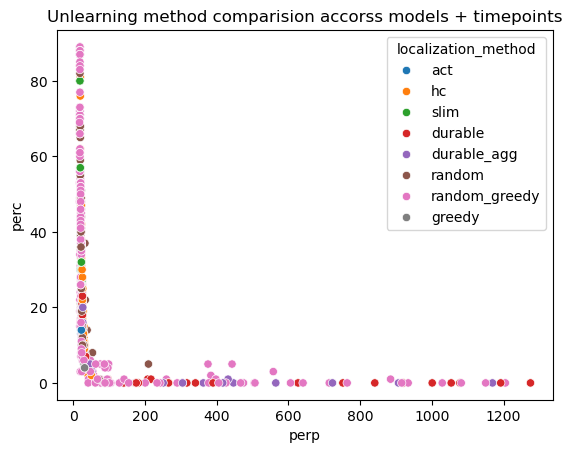

In [61]:
super_df = pd.concat(dfs, axis=0, ignore_index=True)
sns.scatterplot(x="perp",
                y="perc",
                data=super_df,
                hue="localization_method")
plt.title("Unlearning method comparision accorss models + timepoints")

# Unlearn Accross Time

In [62]:
seq_before = []
seq_after = []
ckpt_dir = "/pscratch/sd/m/mansisak/memorization/model_ckpts/"
steps = [36000, 72000, 108000, 143000]
for step in steps:

    #load original mem set
    mem_seq_original = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/mem_seq_pythia-2.8b-deduped',map_location=torch.device('cpu'))
    seq_before.append(mem_seq_original)

    #load mem set after unlearning
    mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/act/mem/0.01/mem_seq_pythia-2.8b-deduped', map_location=torch.device('cpu'))
    #mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/greedy/mem/1e-05/mem_seq_pythia-2.8b-deduped')
    #mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/random_greedy/mem/0.01/1/0.1/0.9/0.0005/mem_seq_pythia-2.8b-deduped')
    #mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/durable/mem/0.01/mem_seq_pythia-6.9b-deduped',map_location=torch.device('cpu'))
    seq_after.append(mem_seq_after_edit)

In [63]:
for seq in seq_before:
    print(seq.shape)

torch.Size([140, 80])
torch.Size([188, 80])
torch.Size([243, 80])
torch.Size([270, 80])


In [64]:
for seq in seq_after:
    if type(seq) == list:
        seq = torch.Tensor(seq)
    print(seq.shape)

torch.Size([47, 80])
torch.Size([57, 80])
torch.Size([80, 80])
torch.Size([69, 80])


In [65]:
def get_common_mem_seq_at_all_time(seq_before):
    #bc we unlearn at different time points, we want to find a common subset of points that is memorized at each training set
    
    base_mem_seq = seq_before[0] # the earliest timepiont has fewest mem seqence
    common_seqs = []
    for row in base_mem_seq: #iterate thru all rows of base mem seq
        common = False
        for seq in seq_before: #see if later time points contain it
            if row in seq:
                common=True
                
        if common:
            common_seqs.append(copy.deepcopy(row.cpu()))
    
    return torch.stack(common_seqs, dim=0)

In [66]:
common_seqs = get_common_mem_seq_at_all_time(seq_before)

In [67]:
common_seqs.shape #there are 80 common seqences memorized at each time point (we will compare unlearning methods on these 80 sequences

torch.Size([140, 80])

In [68]:
def check_overlap(seq_after, common_seqs, steps=steps):
    #Now we want to compare unlearning at multiple timepoints!
    not_unlearn_set_over_time = []
    for seq in seq_after:
        #print(seq.shape)
        #print(seq.shape)
        if type(seq) == list:
            seq = torch.Tensor(seq)
        seq = seq.to("cpu")
        not_unlearn_set = []
        count = 0
        #print(seq)
        #print(common_seqs)
        for row in seq:
            for c in common_seqs:
                if torch.equal(row, c):
                    #print("row not unlearned")
                    not_unlearn_set.append(copy.deepcopy(row))
                    count += 1
        #print("count: ", count)
        #print(torch.stack(not_unlearn_set, dim=0).shape)
        if not_unlearn_set != []:
            not_unlearned_set = torch.stack(not_unlearn_set, dim=0)
        else:
            not_unlearned_set = torch.Tensor([])
        not_unlearn_set_over_time.append(copy.deepcopy(not_unlearned_set))
        
    print("Common Mem seqence count: ", common_seqs.shape)
    
    perc_unlearns = {
        "step":[],
        "perc_unlearn":[]
    
    }
    for i in range(len(steps)):
        step = steps[i]
        #print("# of not unlearned seqences: ", not_unlearn_set_over_time[i].shape)
        perc_unlearn = 100 * (common_seqs.shape[0] - not_unlearn_set_over_time[i].shape[0])/ common_seqs.shape[0]
        #print(f"Perc unlearn @ step {step}: ", perc_unlearn, "%")
        perc_unlearns["step"].append(step)
        perc_unlearns["perc_unlearn"].append(perc_unlearn)
    
    return pd.DataFrame.from_dict(perc_unlearns) # we wnat to know how many of these sequenes were unlearned overtime
    

In [69]:
check_overlap(seq_after, common_seqs)

Common Mem seqence count:  torch.Size([140, 80])


,step,perc_unlearn
0,36000,70.000000
1,72000,69.285714
2,108000,66.428571
3,143000,70.000000


Interestingly in the above setting, it appears the same unlearning method (act), unlearns worse at later timesteps, rather than earlier timesteps

In [70]:
# interpret results!

# Iterate through all models (epochs)

In [72]:
def print_edited_model_paths(parent_path):
    list_of_models = []
    dfs = []

    total_exp = 0
    for model_name in ["pythia-6.9b-deduped", "pythia-2.8b-deduped"]:
        y_idx = 0
        for loc_method in [
            "act",
            "hc",
            "slim",
            "durable",
            "durable_agg",
            "random",
            "random_greedy",
            "greedy",
        ]: 
            for ratio in [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25, 0.3, 0.5, 0.8]:
                for epochs in [1, 10, 20]:
                    for loss_weight in [0.9, 0.7, 0.5,]:
                        
                        if epochs > 1:
                            if loc_method not in ["slim", "hc","random", "random_greedy"]:
                                continue
                        if loss_weight > 0.9:
                            if loc_method not in ["random_greedy"]:
                                continue
                        if loc_method not in ["random", "random_greedy"]:
                            if ratio >= 0.1:
                                continue

                        
                        seq_before = []
                        seq_after = []
                        steps = [36000, 72000, 108000, 143000]
                        for step in steps:
                            result_path = (
                                f"{parent_path}{step}/EleutherAI_edit/{loc_method}/mem/{ratio}"
                            )


                            # this ratio is too small for neuron-level methods
                            if loc_method in ["zero", "hc", "ig", "slim", "act"]:
                                if ratio <= 0.0001:
                                    continue

                            if loc_method in ["greedy"]:
                                if ratio > 0.00001:
                                    continue

                            ######
                            if loc_method in ["greedy", "durable", "durable_agg", "act"]:
                                model_path = f"{result_path}/{model_name}"
                                mem_seq_path = f"{result_path}/mem_seq_{model_name}"
                                total_exp += 1

                            if loc_method in ["slim", "hc"]:
                                    total_exp += 1
                                    model_path = (
                                        f"{result_path}/{epochs}/1000/0.1/0.1/{model_name}"
                                    )
                                    mem_seq_path = model_path = (
                                        f"{result_path}/{epochs}/1000/0.1/0.1/mem_seq_{model_name}"
                                    )

                            if loc_method in ["random"]:
                                    total_exp += 1
                                    model_path = (
                                        f"{result_path}/{epochs}/0.1/0.9/0.0005/{model_name}"
                                    )
                                    mem_seq_path = (
                                        f"{result_path}/{epochs}/0.1/0.9/0.0005/mem_seq_{model_name}"
                                    )

                            if loc_method in ["random_greedy"]:
                                    #print("random_greedy")
                                    total_exp += 1
                                    model_path = (
                                        f"{result_path}/{epochs}/0.1/0.9/0.0005/{loss_weight}/{model_name}"
                                    )
                                    mem_seq_path = (
                                        f"{result_path}/{epochs}/0.1/0.9/0.0005/{loss_weight}/mem_seq_{model_name}"
                                    )

                            if os.path.isfile(model_path):
                                #print("edited model exists:", model_path)
                                #print(mem_seq_path)
                                list_of_models.append(model_path)


                                #load original mem set
                                if "2" in model_name:
                                    mem_seq_original = torch.load(f'{parent_path}{step}/EleutherAI_edit/mem_seq_pythia-2.8b-deduped',map_location=torch.device('cpu'))
                                if "6" in model_name:
                                    mem_seq_original = torch.load(f'{parent_path}{step}/EleutherAI_edit/mem_seq_pythia-6.9b-deduped',map_location=torch.device('cpu'))
                                seq_before.append(mem_seq_original)
                                #print(len(seq_before))

                                #load mem set after unlearning
                                mem_seq_after_edit = torch.load(mem_seq_path,map_location=torch.device('cpu'))
                                seq_after.append(mem_seq_after_edit)

                            else:
                                print("edited model doesn't exist yet: ", model_path)  
                                
                        if len(seq_before) == len(steps):
                            common_seqs = get_common_mem_seq_at_all_time(seq_before)
                            df = check_overlap(seq_after, common_seqs)
                            df.loc[:,"loc_method"] = loc_method
                            dfs.append(df)


    print("total_expeirments: ", total_exp)
    return list_of_models, pd.concat(dfs)

parent_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/"

list_of_models, df =  print_edited_model_paths(parent_path)

Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence count:  torch.Size([213, 80])
Common Mem seqence c

In [73]:
df.loc_method.unique()

array(['act', 'hc', 'slim', 'durable', 'durable_agg', 'random',
       'random_greedy', 'greedy'], dtype=object)

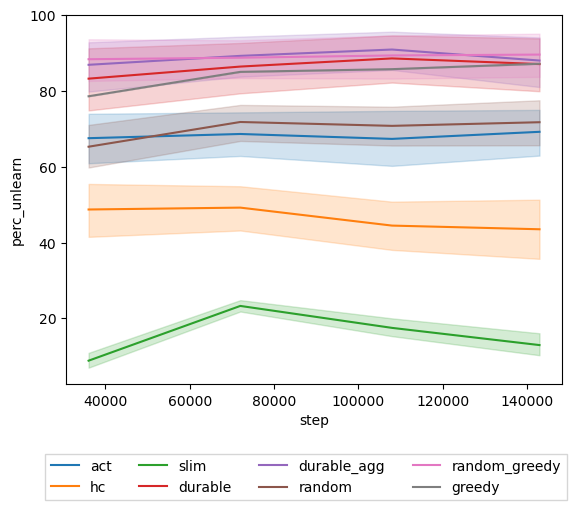

In [74]:
fig, axs = plt.subplots( 1, sharex=True, sharey=True)

ax = sns.lineplot(x="step", y="perc_unlearn", hue="loc_method", data=df, ax=axs)
ax.get_legend().remove()

handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center')
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, -0.02),fancybox=False, shadow=False, ncol=4)
plt.savefig(f"pythia_compare_localization_over_time_plot.pdf", bbox_inches='tight')

# Git commit

In [ ]:
!git add /pscratch/sd/m/mansisak/memorization/figs/pythia_unlearning_results.ipynb
!git commit -m "updated unlearning visualization/analysis"